<a href="https://colab.research.google.com/github/sonudoo/DSA/blob/master/Machine%20Learning/TriggerWordDetectionUsingKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt
import IPython
import numpy as np
from keras.layers import Dense, GRU, Activation, BatchNormalization, Dropout, Conv1D, Input, TimeDistributed
from keras.models import Model
from google.colab import drive

Using TensorFlow backend.


In [27]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
n_activates = 9
n_negatives = 10
n_backgrounds = 2
rate = 44100 # Audio sample rate per second
audio_duration = 10 # Each audio length in second

Tx = rate * audio_duration
Ty = 977
m = 4000 # Example set size
s_length = 50 # Number of ones to be inserted in Y after a trigger word is said

gap_between_inserted_samples = Tx // 5 # Minimum gap between inserted samples in background
ratio = 0.25 # Ratio of amplitude of background to inserted sample

In [4]:
X = []
Y = []

backgrounds = []
activates = []
negatives = []

for i in range(1, n_backgrounds + 1):
    _, background = wavfile.read("/content/drive/My Drive/Colab Notebooks/datasets/ACTIVATE/backgrounds/" + str(i) + ".wav")
    if background.ndim != 1:
        background = np.copy(background[:, 0]) # Extract only one channel
    backgrounds.append(background)

for i in range(1, n_activates + 1):
    _, activate = wavfile.read("/content/drive/My Drive/Colab Notebooks/datasets/ACTIVATE/activates/" + str(i) + ".wav")
    if activate.ndim != 1:
        activate = np.copy(activate[:, 0]) # Extract only one channel
    activates.append(activate)
    
for i in range(1, n_negatives + 1):
    _, negative = wavfile.read("/content/drive/My Drive/Colab Notebooks/datasets/ACTIVATE/negatives/" + str(i) + ".wav")
    if negative.ndim != 1:
        negative = np.copy(negative[:, 0]) # Extract only one channel
    negatives.append(negative)
    

for i in range(m):
  
    background = np.copy(backgrounds[np.random.randint(0, n_backgrounds)])
    l_background = background.shape[0]
   
    next_segment_insertion_start = 0
    
    Y_sample = [0 for _ in range(Ty)]
    
    # Between every inserted activate/negative, we have a gap of at least s_length
    
    while next_segment_insertion_start < l_background:
        
        chance = np.random.randint(0, 2) # Whether to insert activate or negative
        
        if chance == 0:
            
            # Insert a negative
            
            negative = np.copy(negatives[np.random.randint(0, n_negatives)])
            l_negative = negative.shape[0]
            
            if next_segment_insertion_start + l_negative > l_background:
                break
            else:
                background[next_segment_insertion_start: next_segment_insertion_start + l_negative] = ratio * background[next_segment_insertion_start: next_segment_insertion_start + l_negative] + (1 - ratio) * negative
                next_segment_insertion_start += l_negative
            
        elif chance == 1:
            
            # Insert an activate
    
            activate = np.copy(activates[np.random.randint(0, n_activates)])
            l_activate = activate.shape[0]
            
            if next_segment_insertion_start + l_activate > l_background:
                break
            else:
                background[next_segment_insertion_start: next_segment_insertion_start + l_activate] = ratio * background[next_segment_insertion_start: next_segment_insertion_start + l_activate] + (1 - ratio) * activate
                next_segment_insertion_start += l_activate
            
                # Get the start point in corresponding Y_sample array
                
                start = int((next_segment_insertion_start / Tx) * Ty)
                end = start + s_length
                
                for j in range(start, min(end, Ty)):
                    Y_sample[j] = 1
        
        next_segment_insertion_start += gap_between_inserted_samples
    
    # Uncommment the line below to save the samples
    # wavfile.write("/content/drive/My Drive/Colab Notebooks/datasets/ACTIVATE/" + str(i) +".wav", rate, data=background)
    X.append(background)
    Y.append(Y_sample)
    if (i + 1) % 1000 == 0:
      print(i + 1, " samples generated")

X = np.array(X)
Y = np.array(Y)

1000  samples generated
2000  samples generated
3000  samples generated
4000  samples generated


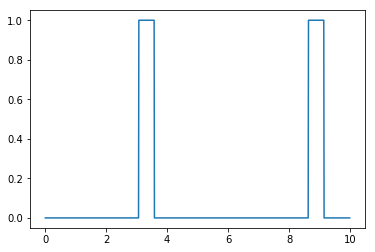

In [5]:
idx = np.random.randint(0, m)

# There are Ty elements in Y. Mapping each time to an equivalent time in 10 second sample gives formula - (i / Ty) * 10
plt.plot([(i / Ty) * 10 for i in range(Ty)], Y[idx])
IPython.display.Audio(rate=rate, data=X[idx])

In [6]:
print(X.shape)
print(Y.shape)

(4000, 441000)
(4000, 977)


In [0]:
# Split to train and test

X_train = []
Y_train = []

X_test = []
Y_test = []

m_train = int(0.9 * m)
m_test = m - m_train

for i in range(0, m_train):
    X_train.append(X[i])
    Y_train.append(Y[i])

for i in range(m_train, m):
    X_test.append(X[i])
    Y_test.append(Y[i])


X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)

X_test = np.array(X_test)
Y_test = np.array(Y_test)
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)

In [0]:
# Apply spectrogram to X. We apply it one by one due to memory constraints

X_train_spectrogram = []
X_test_spectrogram = []

for i in range(0, m_train):
    _, _, spectrogram = signal.spectrogram(X_train[i], rate)
    X_train_spectrogram.append(spectrogram.T)

for i in range(0, m_test):
    _, _, spectrogram = signal.spectrogram(X_test[i], rate)
    X_test_spectrogram.append(spectrogram.T)


X_train_spectrogram = np.array(X_train_spectrogram)
X_test_spectrogram = np.array(X_test_spectrogram)

In [9]:
print(X_train_spectrogram.shape)

(3600, 1968, 129)


In [10]:
# Build the model

X_input = Input(shape=(X_train_spectrogram[0].shape))

Y = Conv1D(kernel_size=15, strides=2, filters=196)(X_input)
Y = BatchNormalization(axis=-1)(Y)
Y = Activation('relu')(Y)
Y = Dropout(rate=0.8)(Y)

Y = GRU(128, return_sequences=True)(Y)
Y = Dropout(0.8)(Y)
Y = BatchNormalization(axis=-1)(Y)

Y = GRU(128, return_sequences=True)(Y)
Y = Dropout(0.8)(Y)
Y = BatchNormalization(axis=-1)(Y)
Y = Dropout(0.8)(Y)

Y = TimeDistributed(Dense(1, activation = "sigmoid"))(Y)

model = Model(inputs=X_input, outputs=Y)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1968, 129)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 977, 196)          379456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 977, 196)          784       
_________________________________________________________________
activation_1 (Activation)    (None, 977, 196)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 977, 196)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 977, 128)          124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 977, 128)          0   

In [15]:
# You might need to train several times. Loss must fall below 0.04 and accuracy must be more than 98.5%

model.fit(X_train_spectrogram, Y_train, epochs=1, batch_size=512)

Epoch 1/1
3600/3600 [==============================] - 39s 11ms/step - loss: 0.0354 - acc: 0.9873


In [16]:
print("Test accuracy:", model.evaluate(X_test_spectrogram, Y_test)[1])

400/400 [==============================] - 16s 40ms/step
Test accuracy: 0.9861412334442139


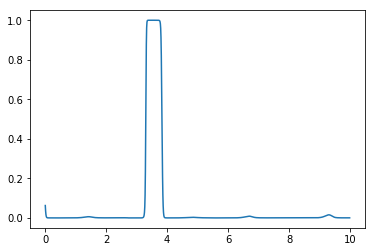

In [17]:
idx = np.random.randint(0, m_test)
Y_pred = model.predict(X_test_spectrogram[idx].reshape(1, X_test_spectrogram[idx].shape[0], X_test_spectrogram[idx].shape[1]))
# There are Ty elements in Y. Mapping each time to an equivalent time in 10 second sample gives formula - (i / Ty) * 10
plt.plot([(i / Ty) * 10 for i in range(Ty)], Y_pred[0])
IPython.display.Audio(rate=rate, data=X_test[idx])

In [29]:
# Test on our own recording. Ensure it a mono wav file of duration less than 10 second and 44100 sample rate

_, my_audio = wavfile.read("/content/drive/My Drive/Colab Notebooks/datasets/ACTIVATE/tests/3.wav")
if my_audio.shape[0] > Tx:
    # Clip the audio
    my_audio = my_audio[0: Tx]
else:
    # Pad the audio
    my_audio = np.pad(my_audio, pad_width=((0, Tx - my_audio.shape[0])), mode='constant')

_, _, my_audio_spectrogram = signal.spectrogram(my_audio, rate)
my_audio_spectrogram = my_audio_spectrogram.T

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


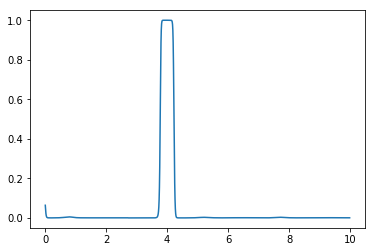

In [30]:
Y_pred = model.predict(my_audio_spectrogram.reshape(1, my_audio_spectrogram.shape[0], my_audio_spectrogram.shape[1]))

# There are Ty elements in Y. Mapping each time to an equivalent time in 10 second sample gives formula - (i / Ty) * 10

plt.plot([(i / Ty) * 10 for i in range(Ty)], Y_pred[0])
IPython.display.Audio(rate=rate, data=my_audio)

In [0]:
# Conclusion: Not so well trained as to do good in real life example.